In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import HuberRegressor

In [4]:
df = pd.read_csv('../../../data/preprocessed/combined_data_preprocessed_Kbest_v1.csv')

In [5]:
X = df.drop(['price_per_m2'], axis=1)
y = df['price_per_m2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Advanced target transformation
target_transformer = PowerTransformer(method='yeo-johnson')
y_train_trans = target_transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_trans = target_transformer.transform(y_test.values.reshape(-1, 1)).flatten()

In [7]:
def inverse_transform(y_trans):
    return target_transformer.inverse_transform(y_trans.reshape(-1, 1)).flatten()

In [8]:
# Outlier detection using Elliptic Envelope
print("Detecting outliers...")
outlier_detector = EllipticEnvelope(contamination=0.05, random_state=42)
outliers = outlier_detector.fit_predict(X_train)
inlier_mask = (outliers == 1)

Detecting outliers...


d:\anaconda\envs\env_v3.10\lib\site-packages\sklearn\covariance\_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [9]:
# Apply outlier mask to training data
X_train_clean = X_train[inlier_mask]
y_train_clean = y_train_trans[inlier_mask]
print(f"Removed {len(X_train) - len(X_train_clean)} outliers from training data")

Removed 328 outliers from training data


In [10]:
# Create robust ensemble model
robust_scaler = RobustScaler()  # Handles outliers in features

In [11]:
# Define base models with outlier-resistant properties
base_models = [
    ('huber', make_pipeline(
        robust_scaler,
        HuberRegressor(epsilon=1.5, max_iter=1000)
    )),
    ('svr', make_pipeline(
        robust_scaler,
        SVR(kernel='rbf', C=10, epsilon=0.1, gamma=0.01)
    )),
    ('gbr', GradientBoostingRegressor(
        loss='huber', alpha=0.95,  # Quantile regression approach
        n_estimators=500, max_depth=5,
        min_samples_leaf=5, random_state=42)
    )
]

In [12]:
# Create ensemble
ensemble = VotingRegressor(
    estimators=base_models,
    weights=[1, 1, 2],  # Give more weight to Gradient Boosting
    n_jobs=-1
)

In [13]:
# Hyperparameter optimization with Optuna
def objective(trial):
    # Huber parameters
    huber_epsilon = trial.suggest_float('huber_epsilon', 1.1, 2.0)
    
    # SVR parameters
    svr_C = trial.suggest_float('svr_C', 1, 100, log=True)
    svr_epsilon = trial.suggest_float('svr_epsilon', 0.01, 0.5)
    svr_gamma = trial.suggest_categorical('svr_gamma', ['scale', 'auto']) or trial.suggest_float('svr_gamma', 0.001, 0.1, log=True)
    
    # GBR parameters
    gbr_n_estimators = trial.suggest_int('gbr_n_estimators', 300, 1000)
    gbr_max_depth = trial.suggest_int('gbr_max_depth', 3, 8)
    gbr_alpha = trial.suggest_float('gbr_alpha', 0.8, 0.99)  # For quantile-like behavior
    
    # Create models with new parameters
    models = [
        ('huber', make_pipeline(
            RobustScaler(),
            HuberRegressor(epsilon=huber_epsilon, max_iter=1000)
        )),
        ('svr', make_pipeline(
            RobustScaler(),
            SVR(kernel='rbf', C=svr_C, epsilon=svr_epsilon, gamma=svr_gamma)
        )),
        ('gbr', GradientBoostingRegressor(
            loss='huber', alpha=gbr_alpha,
            n_estimators=gbr_n_estimators, max_depth=gbr_max_depth,
            min_samples_leaf=5, random_state=42)
        )
    ]
    
    ensemble = VotingRegressor(estimators=models, n_jobs=-1)
    
    # Use cleaned training data
    score = cross_val_score(
        ensemble, 
        X_train_clean, 
        y_train_clean, 
        cv=3, 
        scoring='r2', 
        n_jobs=-1
    ).mean()
    
    return score

print("\nOptimizing ensemble for outlier resistance...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-06-23 23:14:00,323] A new study created in memory with name: no-name-d3a0f78c-2931-4766-8abb-a33ccb6af45c



Optimizing ensemble for outlier resistance...


[I 2025-06-23 23:14:52,690] Trial 0 finished with value: 0.7217674624345752 and parameters: {'huber_epsilon': 1.6925933427984594, 'svr_C': 53.018071751426376, 'svr_epsilon': 0.052688665129041544, 'svr_gamma': 'auto', 'gbr_n_estimators': 678, 'gbr_max_depth': 3, 'gbr_alpha': 0.8069607481028481}. Best is trial 0 with value: 0.7217674624345752.
[I 2025-06-23 23:16:39,905] Trial 1 finished with value: 0.7668135083338553 and parameters: {'huber_epsilon': 1.2774889040993922, 'svr_C': 1.707298276861782, 'svr_epsilon': 0.042094496134853096, 'svr_gamma': 'scale', 'gbr_n_estimators': 939, 'gbr_max_depth': 8, 'gbr_alpha': 0.8169989518244646}. Best is trial 1 with value: 0.7668135083338553.
[I 2025-06-23 23:17:42,590] Trial 2 finished with value: 0.7437446693731902 and parameters: {'huber_epsilon': 1.7001586451912263, 'svr_C': 10.02654637544122, 'svr_epsilon': 0.1396523502788157, 'svr_gamma': 'auto', 'gbr_n_estimators': 502, 'gbr_max_depth': 6, 'gbr_alpha': 0.9259448183305682}. Best is trial 1 wit

In [14]:
# Create optimized ensemble with best parameters
best_params = study.best_params
optimized_ensemble = VotingRegressor(
    estimators=[
        ('huber', make_pipeline(
            RobustScaler(),
            HuberRegressor(
                epsilon=best_params['huber_epsilon'], 
                max_iter=1000)
        )),
        ('svr', make_pipeline(
            RobustScaler(),
            SVR(
                kernel='rbf',
                C=best_params['svr_C'],
                epsilon=best_params['svr_epsilon'],
                gamma=best_params['svr_gamma']
            )
        )),
        ('gbr', GradientBoostingRegressor(
            loss='huber',
            alpha=best_params['gbr_alpha'],
            n_estimators=best_params['gbr_n_estimators'],
            max_depth=best_params['gbr_max_depth'],
            min_samples_leaf=5,
            random_state=42
        ))
    ],
    weights=[1, 1, 2],
    n_jobs=-1
)

In [15]:
# Train on cleaned data
optimized_ensemble.fit(X_train_clean, y_train_clean)

VotingRegressor(estimators=[('huber',
                             Pipeline(steps=[('robustscaler', RobustScaler()),
                                             ('huberregressor',
                                              HuberRegressor(epsilon=1.438913563578062,
                                                             max_iter=1000))])),
                            ('svr',
                             Pipeline(steps=[('robustscaler', RobustScaler()),
                                             ('svr',
                                              SVR(C=21.140813425850336,
                                                  epsilon=0.015020995708470913))])),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.8535003489558445,
                                                       loss='huber',
                                                       max_depth=7,
                                                       min_samples_leaf=5,
                                                       n_estimators=822,
                                                       random_state=42))],
                n_jobs=-1, weights=[1, 1, 2])

In [16]:
# Final evaluation function
def evaluate_model(model, X, y_true_trans):
    y_pred_trans = model.predict(X)
    y_pred = inverse_transform(y_pred_trans)
    y_true = inverse_transform(y_true_trans)
    
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.percentile(y_true, 75), 1e-8))) * 100  # Use IQR for more robust MAPE
    
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"Robust MAPE (IQR): {mape:.2f}%")
    print(f"Median Price: {np.median(y_true):.2f}")
    
    return y_pred

In [17]:
# Evaluate on test set
print("\nOptimized Ensemble Performance (Clean Training):")
y_pred_ensemble = evaluate_model(optimized_ensemble, X_test, y_test_trans)


Optimized Ensemble Performance (Clean Training):
R²: 0.7056
MAE: 358.56
Robust MAPE (IQR): 14.34%
Median Price: 1666.67


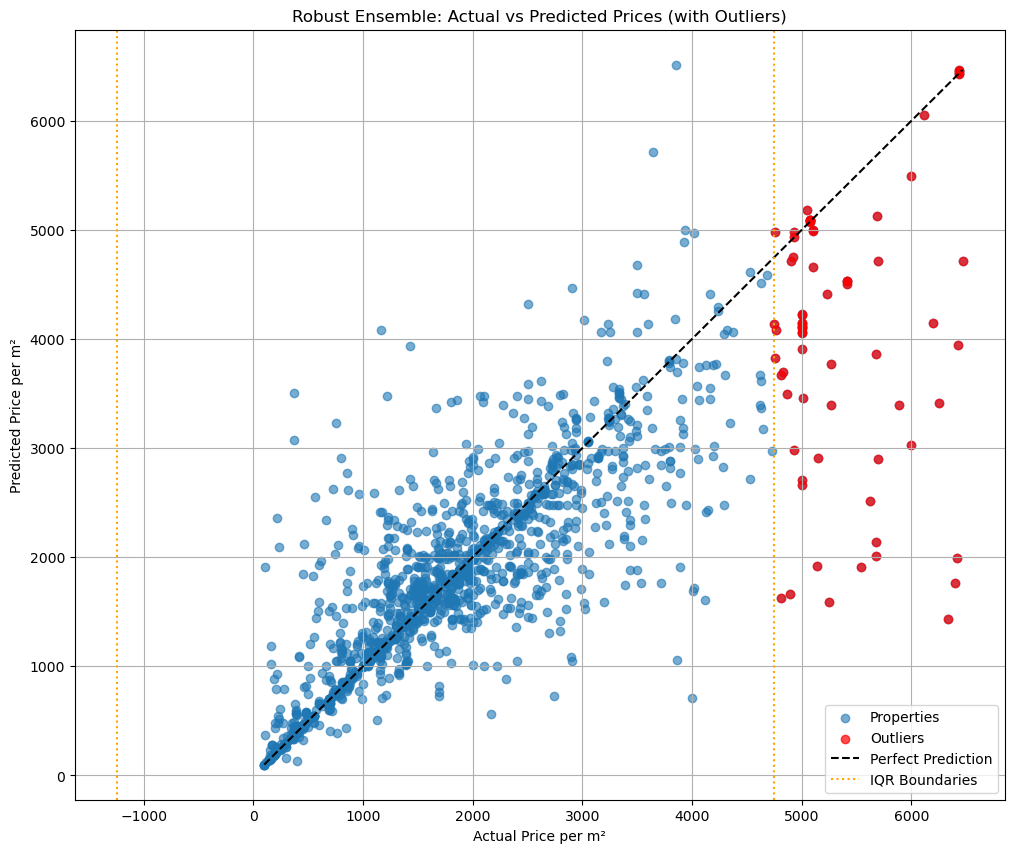

In [18]:
# Plot actual vs predicted with outlier visualization
def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(12, 10))
    
    # Main scatter plot
    plt.scatter(y_true, y_pred, alpha=0.6, label='Properties')
    
    # Add IQR boundaries
    q1 = np.percentile(y_true, 25)
    q3 = np.percentile(y_true, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    
    # Identify outliers
    outlier_mask = (y_true < lower_bound) | (y_true > upper_bound)
    plt.scatter(y_true[outlier_mask], y_pred[outlier_mask], 
                c='red', alpha=0.7, label='Outliers')
    
    # Reference lines
    plt.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 'k--', label='Perfect Prediction')
    plt.axvline(x=lower_bound, color='orange', linestyle=':', label='IQR Boundaries')
    plt.axvline(x=upper_bound, color='orange', linestyle=':')
    
    plt.xlabel('Actual Price per m²')
    plt.ylabel('Predicted Price per m²')
    plt.title('Robust Ensemble: Actual vs Predicted Prices (with Outliers)')
    plt.legend()
    plt.grid(True)
    plt.savefig("robust_ensemble_outlier_plot.png")
    plt.show()

y_test_actual = inverse_transform(y_test_trans)
plot_actual_vs_predicted(y_test_actual, y_pred_ensemble)

In [ ]:
from sklearn.inspection import permutation_importance
# Feature importance using permutation importance
print("\nCalculating feature importance...")
result = permutation_importance(
    optimized_ensemble, 
    X_test, 
    y_test_trans, 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)


Calculating feature importance...


In [ ]:
# Plot importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(12, 10))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X.columns[sorted_idx]
)
plt.title("Permutation Importances (Robust Ensemble)")
plt.tight_layout()
plt.savefig("robust_ensemble_feature_importance.png")
plt.show()